In [1]:
  #!/usr/bin/env python
from __future__ import division
import argparse 
import numpy as np
from fipy import *
import time
import matplotlib
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {'text.usetex' : True,
          'font.size' : 9,
          'font.family' : 'lmodern'
          }
plt.rcParams.update(params) 
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

/Users/sharmila/anaconda3/envs/py36_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  


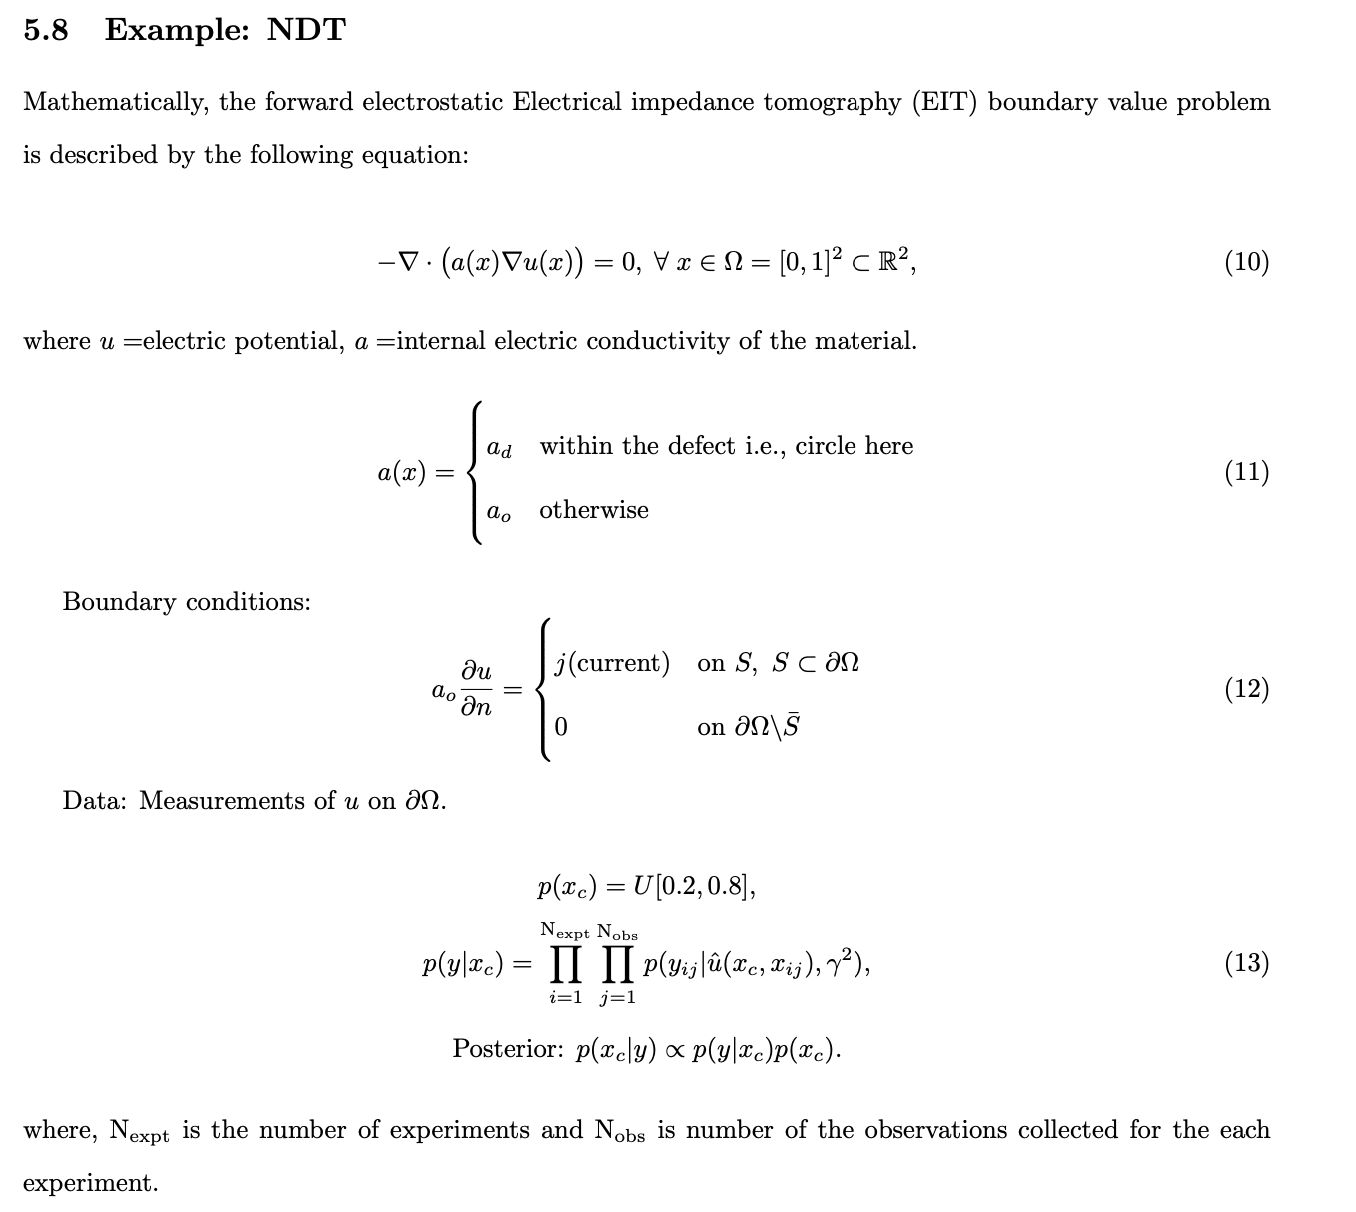

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = "EIT.png") # width=700, height=700

In [3]:
# nx1, nx2 = 101, 101 or 199, 199 or 297, 297 or 395, 395

In [4]:
class EIT_fipy():
    """
    Class that solves forward electrostatic EIT BVP for different boundary conditions using fipy package for a circular damage.
    x_center:  Location of the damage center.
    """
    def __init__(self, x_center):
        
        # defect with radius r at x_center
        self.r = 0.1
        self.x_center = x_center
        
        # electrical conductivities
        self.a_d = 1.5
        self.a_o = 10
        
        self.Expts_description = {
                                'Expt-1': 'Unit current applied on all the sides',
                                'Expt-2': 'Unit current on left and right, no current on the other sides',
                                'Expt-3': 'Unit current on top and bottom, no current on the other sides'
                                }
        # Applying unit current on the Neumann boundaries
        self.j = 1 # unit current
        # Boundary conditions value: [left, right, top, bottom]
        self.BCs = {
                'Expt-1': [self.j/self.a_o, self.j/self.a_o, self.j/self.a_o, self.j/self.a_o],
                'Expt-2': [self.j/self.a_o, self.j/self.a_o, 0, 0],
                'Expt-3': [0, 0, self.j/self.a_o, self.j/self.a_o]
                }

        # defining mesh to get cellcenters
        self.Lx1 = 1.  # always put . after 1 
        self.Lx2 = 1.  # always put . after 1 
        self.nx1, self.nx2 = 395, 395
        self.f = 0. # source
        
        # define mesh
        self.mesh = Grid2D(nx=self.nx1, ny=self.nx2, dx=self.Lx1/self.nx1, dy=self.Lx2/self.nx2) # with nx1*nx2 number of cells/cellcenters/pixels/pixelcenters
        self.x_fipy = self.mesh.cellCenters.value.T ## fipy solution (nx1*nx2,2) matrix # same as cellcenters defined above
        
    def electrical_conductivity(self):
        """
        Getting required electrical conductivities throughout the domain.
        """
        d = np.linalg.norm(self.x_fipy-self.x_center, axis=1)
        a = np.zeros(len(d))
        for i in range(len(d)):
            if d[i]**2 <= self.r**2:
                a[i] = self.a_d
            elif d[i]**2 > self.r**2:
                a[i] = self.a_o
        return a
         
    def plot_electrical_conductivity(self):
        """
        Plotting the electrical conductivity.
        """
        #mpl.rcParams.update(mpl.rcParamsDefault)
        #plt.rcParams.update({'font.size': 9})
        import matplotlib.ticker as tick
        
        x1_f = self.x_fipy[:,0][:,None] # x1-coordinates of cell centers (nx1*nx2,1) matrix
        x2_f = self.x_fipy[:,1][:,None] # x2-coordinates of cell centers (nx1*nx2,1) matrix
        a = self.electrical_conductivity()

        width = 7.5/2
        height = width/1.6
        fig = plt.figure(figsize=(4,3)) #figsize=(width, height)
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["navy","blue","deepskyblue","limegreen","yellow","darkorange","red","maroon"])
        axes = fig.gca()
        col = axes.contourf(x1_f.reshape((self.nx1, self.nx2)), x2_f.reshape((self.nx1, self.nx2)), a.reshape((self.nx1, self.nx2)), 20, vmin=1.5, vmax=10.0, cmap='Oranges')
        plt.colorbar(col, format=tick.FormatStrFormatter('%.2f'))
        plt.xlabel(r'$x_1$', labelpad=3)
        plt.ylabel(r'$x_2$', rotation="horizontal", labelpad=10)
        #plt.title('Electrical conductivity')
        plt.tight_layout(pad=0.1)
        plt.savefig('Electrical_conductivity_circular'+'.pdf', dpi=300, bbox_inches='tight')
        plt.show()
            
    def solve(self):
        """
        FIPY solution of all the experiments.
        """
        u_fipy_dict = {}
        for expt, args_BCs in self.BCs.items():

            # define cell and face variables
            phi = CellVariable(name='$T(x)$', mesh=self.mesh, value=0.)
            A = CellVariable(name='$D(x)$', mesh=self.mesh, value=1.0) ## coefficient in diffusion equation
            # A = FaceVariable(name='$D(x)$', mesh=self.mesh, value=1.0) ## coefficient in diffusion equation
            source = CellVariable(name='$f(x)$', mesh=self.mesh, value=1.0)

            # apply boundary conditions
            # homogeneous Neumann
            phi.faceGrad.constrain(args_BCs[0], self.mesh.facesLeft)
            phi.faceGrad.constrain(args_BCs[1], self.mesh.facesRight)
            phi.faceGrad.constrain(args_BCs[2], self.mesh.facesTop)
            phi.faceGrad.constrain(args_BCs[3], self.mesh.facesBottom)

            # setup the diffusion problem
            eq = -DiffusionTerm(coeff=A) == source

            source.setValue(self.f)
            a = self.electrical_conductivity()
            A.setValue(a)

            eq.solve(var=phi)

            u_fipy = phi.value[:][:, None] ## fipy solution  (nx1*nx2,1) matrix
            u_fipy_dict[expt] = u_fipy
        return u_fipy_dict
            
    def plot(self, u_fipy_dict): 
        """
        Plotting FIPY solution of all the experiments.
        """  
        #mpl.rcParams.update(mpl.rcParamsDefault)
        #plt.rcParams.update({'font.size': 9})
        import matplotlib.ticker as tick
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["navy","blue","deepskyblue","limegreen","yellow","darkorange","red","maroon"])
        
        for i, expt in zip(range(len(self.BCs)), self.BCs.keys()):
            x1_f = self.x_fipy[:,0][:,None] # x1-coordinates of cell centers (nx1*nx2,1) matrix
            x2_f = self.x_fipy[:,1][:,None] # x2-coordinates of cell centers (nx1*nx2,1) matrix
            
            width = 7.5/2
            height = width/1.6
            fig, ax = plt.subplots(figsize=(4,3)) #figsize=(width, height)
            col = ax.contourf( x1_f.reshape((self.nx1, self.nx2)), x2_f.reshape((self.nx1, self.nx2)), u_fipy_dict[expt].reshape((self.nx1, self.nx2)), 100, cmap='twilight') # set levels as previous levels
            # This is the fix for the white lines between contour levels (https://stackoverflow.com/questions/8263769/hide-contour-linestroke-on-pyplot-contourf-to-get-only-fills)
            for j in col.collections:
                j.set_edgecolor("face")
            plt.colorbar(col, format=tick.FormatStrFormatter('%.2f'))
            #plt.title(f'{expt} (FVM solution)')
            plt.xlabel(r'$x_1$', labelpad=3)
            plt.ylabel(r'$x_2$', rotation="horizontal", labelpad=10)
            plt.tight_layout(pad=0.1)
            plt.savefig('FVM_solution_circular_'+f'{expt}'+'.pdf', dpi=300, bbox_inches='tight')
            plt.show()


Circular damage at x_center: [[0.5 0.5]]
Expt-1 --> Unit current applied on all the sides
Expt-2 --> Unit current on left and right, no current on the other sides
Expt-3 --> Unit current on top and bottom, no current on the other sides


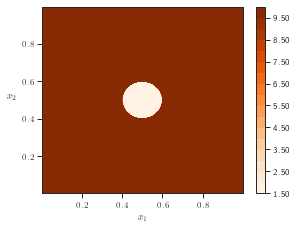

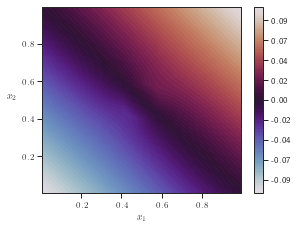

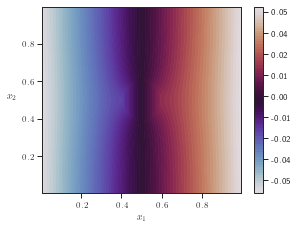

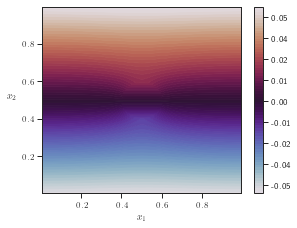

In [5]:
# x_center = np.random.uniform(low=0.2, high=0.8, size=(1, 2)) # restricting the center of the damage to lie within [0.2, 0.8] for all the dimensions
x_center = np.array([[0.5, 0.5]]) #np.array([[0.29, 0.44]])
print('Circular damage at x_center: '+str(x_center))

obj = EIT_fipy(x_center)
for k, v in obj.Expts_description.items():
    print (k, '-->', v)
obj.plot_electrical_conductivity()
u_fipy_dict = obj.solve()
obj.plot(u_fipy_dict)

In [6]:
# x, A(x_c) --> u(x, A(x_c)) # issue of pixels

# x, x_c --> u(x,xc) #****

# x ----> gamma(x)
# x_c-----> xc  

# a --> u #(100, 100)

# x,y, a(x,y, x_c) --> u(x,y)
